In [ ]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Load the model
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.eval()


model.eval()



# # Save the original forward method
# original_attn_forward = model.blocks[-1].attn.forward




c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [4]:
attn_weights = []

def patched_attn_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
    q, k, v = qkv.permute(2, 0, 3, 1, 4)

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    attn_weights.append(attn.detach())  # 💡 Save attention before dropout
    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

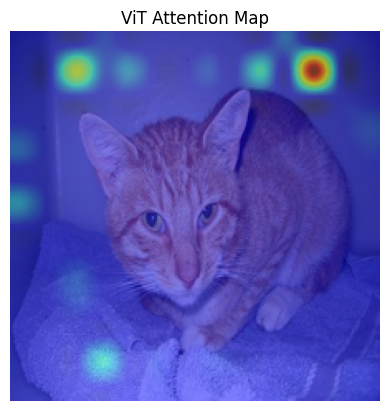

In [5]:
attn_weights = []


# Load and preprocess the image
image_path = r"C:\Users\e0l07sq\Downloads\training_set\training_set\cats\cat.119.jpg"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

input_tensor = transform(img).unsqueeze(0)  # Add batch dimension


# Patch it
model.blocks[-1].attn.forward = patched_attn_forward.__get__(model.blocks[-1].attn, type(model.blocks[-1].attn))
# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Get the attention from the CLS token
attn = attn_weights[0]  # Shape: [batch, heads, tokens, tokens]
cls_attn = attn[0, :, 0, 1:]  # CLS to all patches, ignore CLS->CLS

# Average over heads
mean_attn = cls_attn.mean(dim=0).reshape(14, 14).cpu().numpy()  # ViT has 14x14 patches

# Normalize
mean_attn = (mean_attn - mean_attn.min()) / (mean_attn.max() - mean_attn.min())

# Upsample to image size
import cv2
attn_map = cv2.resize(mean_attn, (224, 224), interpolation=cv2.INTER_CUBIC)

# Show overlay
fig, ax = plt.subplots()
ax.imshow(img.resize((224, 224)))
ax.imshow(attn_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT Attention Map")
plt.show()



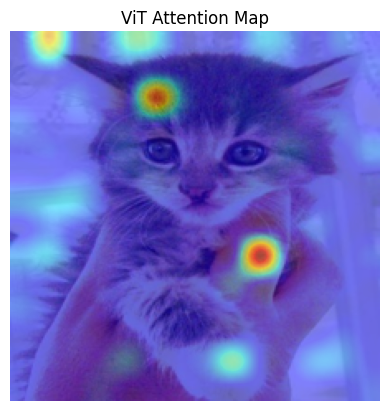

In [8]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import cv2

# Load model
model = timm.create_model("vit_base_patch16_224", pretrained=True)
# checkpoint_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ViT_best.pth"
# state_dict = torch.load(checkpoint_path, map_location='cpu')
# model.load_state_dict(state_dict)
model.eval()


attn_weights = []

# Patch the forward of Attention module correctly
def patched_attn_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    attn_weights.append(attn.detach())  # save attention map

    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# Bind the method properly
model.blocks[-1].attn.forward = patched_attn_forward.__get__(model.blocks[-1].attn, model.blocks[-1].attn.__class__)

# Load and preprocess image
image_path = r"C:\Users\e0l07sq\Downloads\training_set\training_set\cats\cat.100.jpg"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

input_tensor = transform(img).unsqueeze(0)

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Extract attention
attn = attn_weights[0]  # [batch, heads, tokens, tokens]
cls_attn = attn[0, :, 0, 1:]  # CLS token attention to patches only

# Average heads
mean_attn = cls_attn.mean(dim=0).reshape(14, 14).cpu().numpy()

# Normalize
mean_attn = (mean_attn - mean_attn.min()) / (mean_attn.max() - mean_attn.min())

# Resize to image size
attn_map = cv2.resize(mean_attn, (224, 224), interpolation=cv2.INTER_CUBIC)

# Show overlay
fig, ax = plt.subplots()
ax.imshow(img.resize((224, 224)))
ax.imshow(attn_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT Attention Map")
plt.show()


In [9]:
# Forward pass
with torch.no_grad():
    a = model(input_tensor)

In [10]:
a

tensor([[-7.0273e-01,  1.0893e-01, -9.5720e-01, -1.7721e-01, -2.8006e-01,
         -3.9347e-01, -7.9729e-01, -1.5885e-01, -4.1446e-01,  4.8931e-01,
         -7.9140e-01, -6.0761e-01, -1.3886e-01, -4.1732e-01, -9.7124e-02,
          3.7093e-01, -4.8204e-01,  6.6867e-02, -4.6930e-01, -4.2562e-01,
         -1.7331e-01, -6.4818e-02, -7.8913e-01, -5.8385e-01,  4.9306e-02,
         -1.4435e+00, -1.0016e+00, -1.1025e+00, -9.4139e-01,  4.1193e-01,
         -6.5140e-01,  5.9120e-02,  4.4506e-01, -9.4722e-01, -5.6860e-01,
         -6.1567e-01,  3.8152e-01, -4.9078e-01,  3.6928e-01, -4.6611e-01,
         -2.8387e-01, -6.5032e-01, -1.4457e+00, -3.0341e-02, -9.2833e-01,
         -1.1277e+00, -9.5760e-01, -3.8589e-01, -3.2697e-01, -6.5382e-01,
         -1.9101e-01, -2.2600e-02, -1.3766e-01, -1.4406e+00, -1.1292e-01,
         -1.0316e+00, -8.8037e-01, -1.8710e+00, -7.7628e-01, -3.3382e-01,
         -4.1407e-01,  2.2148e-01, -3.8048e-01, -2.2004e-01, -1.0495e+00,
         -2.0133e+00, -2.5824e-01, -1.

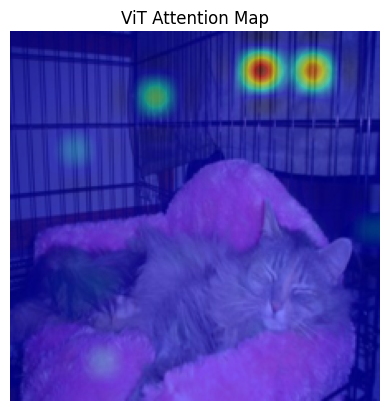

In [30]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import cv2

# Load model
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.eval()


attn_weights = []

# Patch the forward of Attention module correctly
def patched_attn_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)

    attn_weights.append(attn.detach())  # save attention map

    attn = self.attn_drop(attn)
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

# Bind the method properly
model.blocks[-1].attn.forward = patched_attn_forward.__get__(model.blocks[-1].attn, model.blocks[-1].attn.__class__)

# Load and preprocess image
image_path = r"C:\Users\e0l07sq\Downloads\training_set\training_set\cats\cat.120.jpg"
img = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

input_tensor = transform(img).unsqueeze(0)

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Extract attention
attn = attn_weights[0]  # [batch, heads, tokens, tokens]
cls_attn = attn[0, :, 0, 1:]  # CLS token attention to patches only

# Average heads
mean_attn = cls_attn.mean(dim=0).reshape(14, 14).cpu().numpy()

# Normalize
mean_attn = (mean_attn - mean_attn.min()) / (mean_attn.max() - mean_attn.min())

# Resize to image size
attn_map = cv2.resize(mean_attn, (224, 224), interpolation=cv2.INTER_CUBIC)

# Show overlay
fig, ax = plt.subplots()
ax.imshow(img.resize((224, 224)))
ax.imshow(attn_map, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT Attention Map")
plt.show()


In [25]:
# Forward pass
with torch.no_grad():
    a = model(input_tensor)
a

tensor([[-4.8846e-01, -4.3807e-02, -5.9260e-01,  5.7065e-01, -1.1732e-01,
          4.9850e-02,  1.9677e-01,  6.4607e-01,  1.8860e-02, -6.5127e-01,
          7.0542e-01, -2.9058e-01,  1.1775e+00,  5.1746e-02, -3.3192e-01,
          6.9992e-01,  1.1059e+00,  3.6320e-01,  2.1440e-01, -1.5464e-01,
          1.3565e+00,  8.2560e-01,  7.0464e-01,  8.6922e-01, -4.9432e-01,
         -6.0435e-01,  2.6675e-01, -1.2911e-01, -2.3511e-01,  2.5851e-01,
         -8.6874e-03, -9.1021e-01, -2.3934e-02, -6.3277e-01, -5.0678e-01,
          1.6578e-01,  1.0122e+00,  2.2249e-01, -3.2698e-01, -1.7085e-01,
         -8.9937e-01, -1.2510e-01,  6.6720e-01, -4.0211e-01, -2.5222e-01,
         -1.1184e+00, -1.7459e+00, -4.8215e-01, -1.2115e+00, -5.1120e-01,
         -6.3331e-01, -4.2147e-01, -4.8712e-01, -1.0586e+00, -4.5814e-01,
         -1.9806e+00, -4.0779e-01, -2.0817e-01,  2.6911e-01, -1.1508e+00,
         -3.2093e-01, -6.1590e-01, -5.1238e-02, -2.7809e-01, -8.9555e-01,
          1.9751e-02, -7.7358e-02, -1.

In [26]:
import torch
import torch.nn.functional as F

# Assuming `logits` is your output tensor
logits = a  # replace with your actual tensor variable

# Apply softmax to get probabilities
probs = F.softmax(logits, dim=1)

# Get predicted class
pred_class = torch.argmax(probs, dim=1)

# Optional: print results
print("Predicted class index:", pred_class.item())
print("Class probabilities:", probs)

Predicted class index: 283
Class probabilities: tensor([[9.2926e-05, 1.4496e-04, 8.3736e-05, 2.6798e-04, 1.3469e-04, 1.5919e-04,
         1.8439e-04, 2.8898e-04, 1.5434e-04, 7.8964e-05, 3.0664e-04, 1.1326e-04,
         4.9165e-04, 1.5950e-04, 1.0867e-04, 3.0496e-04, 4.5766e-04, 2.1778e-04,
         1.8767e-04, 1.2975e-04, 5.8801e-04, 3.4580e-04, 3.0641e-04, 3.6122e-04,
         9.2383e-05, 8.2758e-05, 1.9775e-04, 1.3311e-04, 1.1972e-04, 1.9613e-04,
         1.5014e-04, 6.0950e-05, 1.4787e-04, 8.0439e-05, 9.1240e-05, 1.7876e-04,
         4.1674e-04, 1.8919e-04, 1.0921e-04, 1.2767e-04, 6.1615e-05, 1.3364e-04,
         2.9515e-04, 1.0131e-04, 1.1769e-04, 4.9497e-05, 2.6427e-05, 9.3515e-05,
         4.5093e-05, 9.0838e-05, 8.0395e-05, 9.9365e-05, 9.3051e-05, 5.2548e-05,
         9.5788e-05, 2.0898e-05, 1.0073e-04, 1.2299e-04, 1.9822e-04, 4.7919e-05,
         1.0987e-04, 8.1807e-05, 1.4389e-04, 1.1468e-04, 6.1850e-05, 1.5447e-04,
         1.4018e-04, 4.7811e-05, 1.0016e-04, 1.3611e-04, 7.43

In [33]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Load a pre-trained ViT model and feature extractor
model_name = 'google/vit-large-patch32-384'
processor = ViTImageProcessor.from_pretrained(model_name, do_rescale=False)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation='eager')

# Run an image through the pipline
inputs = processor(images=img, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

# Getting the attentions
attentions = outputs.attentions 


RuntimeError: Failed to import transformers.models.vit.modeling_vit because of the following error (look up to see its traceback):
Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

NameError: name 'attentions' is not defined

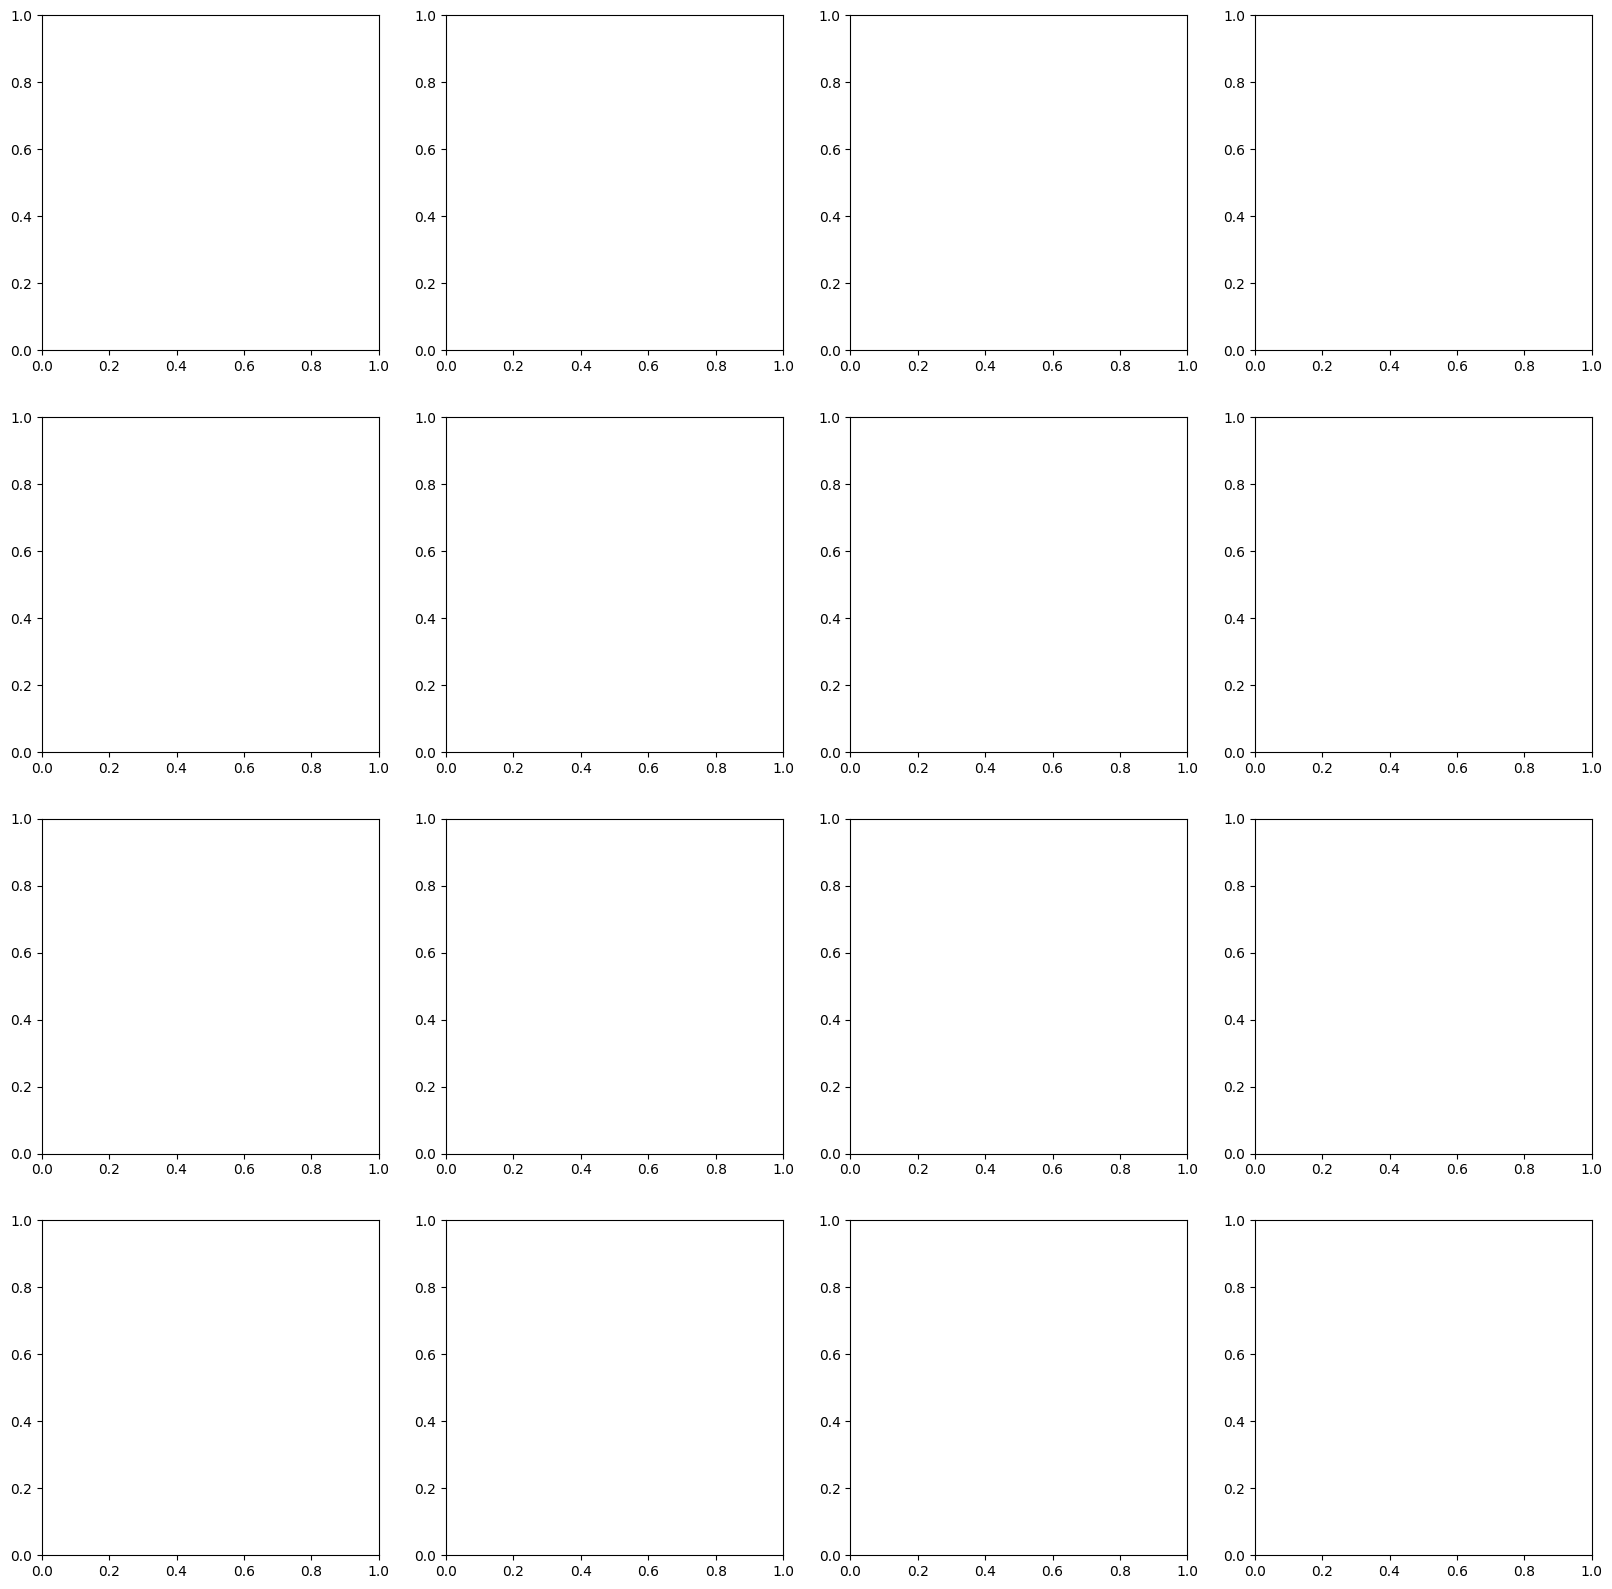

In [34]:
ig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(attentions[-1][0, i, :, :].detach().cpu().numpy())
    ax.axis('off')


In [ ]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

In [ ]:
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))


In [ ]:
# Normalize the attention map for better visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Resize and blur the attention map
cls_attention_resized = Image.fromarray((cls_attention * 255).astype(np.uint8)).resize((img_size, img_size), resample=Image.BICUBIC)
cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))


In [ ]:
# Convert the attention map to RGBA
cls_attention_colored = np.array(cls_attention_resized.convert("L"))
cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)

# Adjust the alpha channel to control brightness
cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
cls_attention_colored_img.putalpha(100)  # Adjust alpha for blending (lower value for darker overlay)


In [7]:
img_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\cropped_data\Normal\Normal 18_right.jpg"

# resnet

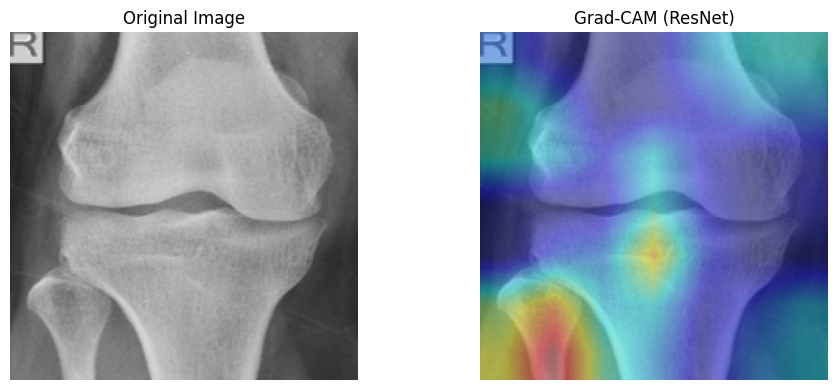

In [8]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch.nn as nn
from collections import OrderedDict

# Set number of classes as used in training
NUM_CLASSES = 2  # ← Replace with your actual number if different

# Define the same custom model structure
def get_custom_resnet(num_classes):
    model = models.resnet50(pretrained=False)
    
    num_ftrs = model.fc.in_features
    
    classifier = nn.Sequential(
        OrderedDict([
            ("fc1", nn.Linear(num_ftrs, 512)),
            ("relu1", nn.ReLU()),
            ("dropout", nn.Dropout(0.5)),
            ("fc2", nn.Linear(512, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ])
    )
    
    model.fc = classifier
    return model

# Instantiate the model with correct head
model = get_custom_resnet(num_classes=NUM_CLASSES)

# Load the weights
weights_path = r'C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ResNet50_best.pth'
state_dict = torch.load(weights_path, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

# Target the last convolutional layer (usually 'layer4[-1]')
target_layer = model.layer4[-1]

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Hook to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, pred_class].backward()

# Get hooked data
grads = gradients[0]  # [B, C, H, W]
acts = activations[0]  # [B, C, H, W]

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

# Normalize and resize CAM
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert image for display
img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Display result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM (ResNet)')
plt.imshow(superimposed[:, :, ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.tight_layout()
plt.show()

# Cleanup
handle_f.remove()
handle_b.remove()


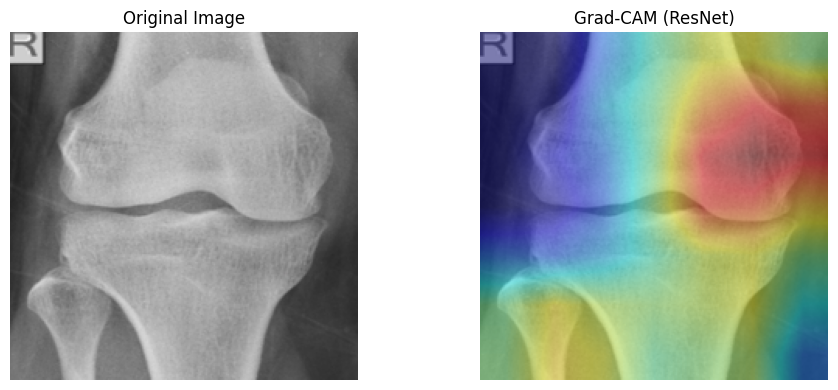

In [9]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load pretrained ResNet
model = models.resnet50(pretrained=True)
model.eval()

# Target the last convolutional layer (usually 'layer4[-1]')
target_layer = model.layer4[-1]

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Hook to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, pred_class].backward()

# Get hooked data
grads = gradients[0]  # [B, C, H, W]
acts = activations[0]  # [B, C, H, W]

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

# Normalize and resize CAM
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert image for display
img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Display result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM (ResNet)')
plt.imshow(superimposed[:, :, ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.tight_layout()
plt.show()

# Cleanup
handle_f.remove()
handle_b.remove()


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch.nn as nn
from collections import OrderedDict

# Set number of classes as used in training
NUM_CLASSES = 2  # ← Replace with your actual number if different

# Define the same custom model structure
def get_custom_resnet(num_classes):
    model = models.resnet50(pretrained=False)
    
    num_ftrs = model.fc.in_features
    
    classifier = nn.Sequential(
        OrderedDict([
            ("fc1", nn.Linear(num_ftrs, 512)),
            ("relu1", nn.ReLU()),
            ("dropout", nn.Dropout(0.5)),
            ("fc2", nn.Linear(512, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ])
    )
    
    model.fc = classifier
    return model

# Instantiate the model with correct head
model = get_custom_resnet(num_classes=NUM_CLASSES)

# Load the weights
weights_path = r'C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ResNet50_best.pth'
state_dict = torch.load(weights_path, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

# Target the last convolutional layer (usually 'layer4[-1]')
target_layer = model.layer4[-1]

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Hook to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, pred_class].backward()

# Get hooked data
grads = gradients[0]  # [B, C, H, W]
acts = activations[0]  # [B, C, H, W]

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

# Normalize and resize CAM
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert image for display
img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Display result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM (ResNet)')
plt.imshow(superimposed[:, :, ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.tight_layout()
plt.show()

# Cleanup
handle_f.remove()
handle_b.remove()


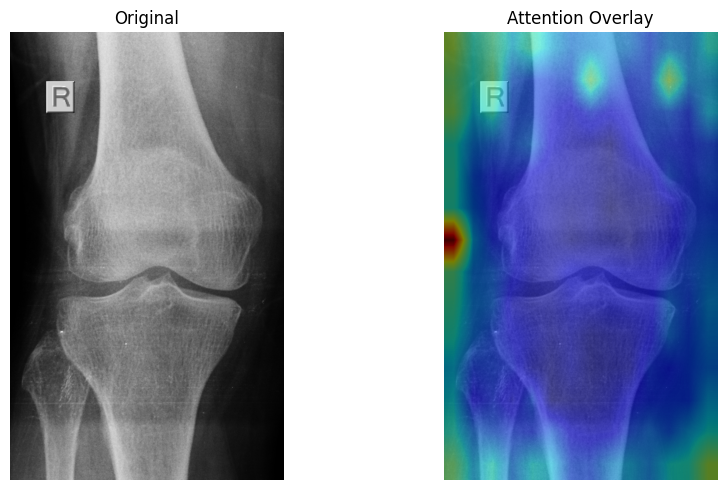

In [33]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2
from io import BytesIO

# Load pretrained ViT
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.eval()

# Store attention maps
attention_maps = []

# Monkey-patch the Attention forward to extract attention weights
def hook_vit_attention(attn_module):
    original_forward = attn_module.forward

    def forward_hook(x):
        B, N, C = x.shape
        qkv = attn_module.qkv(x).reshape(B, N, 3, attn_module.num_heads, C // attn_module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, heads, tokens, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * attn_module.scale
        attn = attn.softmax(dim=-1)
        attention_maps.append(attn.detach())  # Store for rollout

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = attn_module.proj(out)
        out = attn_module.proj_drop(out)
        return out

    attn_module.forward = forward_hook

# Apply patch to all blocks
for block in model.blocks:
    hook_vit_attention(block.attn)

# Preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)

# Forward pass
with torch.no_grad():
    _ = model(input_tensor)

# Rollout function
def compute_rollout(attns):
    result = torch.eye(attns[0].size(-1))
    for attn in attns:
        attn_heads_fused = attn.squeeze(0).mean(dim=0)
        attn_heads_fused += torch.eye(attn_heads_fused.size(0))  # Add residual
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = attn_heads_fused @ result
    return result

rollout = compute_rollout(attention_maps)
# Compute attention map
cls_attention = rollout[0, 1:]
cls_attention = cls_attention.reshape(14, 14).detach().numpy()

# Resize to original image size
orig_w, orig_h = image.size
cls_attention = cv2.resize(cls_attention, (orig_w, orig_h))
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(cls_attention, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Attention Overlay")

plt.tight_layout()
plt.show()


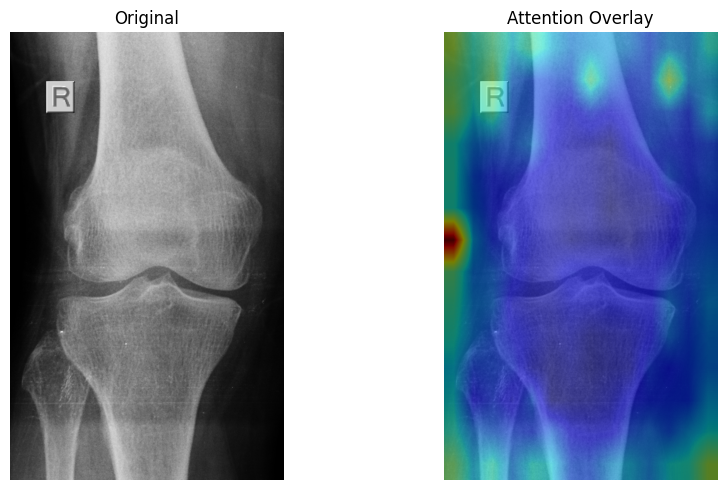

In [39]:
import timm
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# === Load model and apply attention hook ===
attention_maps = []

def hook_vit_attention(attn_module):
    original_forward = attn_module.forward

    def forward_hook(x):
        B, N, C = x.shape
        qkv = attn_module.qkv(x).reshape(B, N, 3, attn_module.num_heads, C // attn_module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * attn_module.scale
        attn = attn.softmax(dim=-1)
        attention_maps.append(attn.detach())

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = attn_module.proj(out)
        out = attn_module.proj_drop(out)
        return out

    attn_module.forward = forward_hook

# Load ViT and apply hooks
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=2)
for block in model.blocks:
    hook_vit_attention(block.attn)

# === Load your saved checkpoint ===
checkpoint_path = r"C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ViT_best.pth"
state_dict = torch.load(checkpoint_path, map_location='cpu')

# In case it was saved with DataParallel or similar wrappers
if 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']
    new_state_dict = {}
    for k, v in state_dict.items():
        new_k = k.replace('module.', '')
        new_state_dict[new_k] = v
    state_dict = new_state_dict

model.load_state_dict(state_dict, strict=False)
model.eval()

# === Load and preprocess image ===
orig_w, orig_h = image.size

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
input_tensor = transform(image).unsqueeze(0)

# === Forward pass ===
with torch.no_grad():
    _ = model(input_tensor)

# === Attention rollout ===
def compute_rollout(attns):
    result = torch.eye(attns[0].size(-1))
    for attn in attns:
        attn_heads_fused = attn.squeeze(0).mean(dim=0)
        attn_heads_fused += torch.eye(attn_heads_fused.size(0))
        attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)
        result = attn_heads_fused @ result
    return result

rollout = compute_rollout(attention_maps)
cls_attention = rollout[0, 1:]  # remove CLS token
cls_attention = cls_attention.reshape(14, 14).detach().numpy()
cls_attention = cv2.resize(cls_attention, (orig_w, orig_h))
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# === Visualization ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(cls_attention, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Attention Overlay")

plt.tight_layout()
plt.show()
